In [1]:
import os
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120
RND = 42
np.random.seed(RND)

In [2]:
# Paths / config
DATA_PATH = "creditcard.csv"   # change if needed
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
# Utility metrics / plotting helpers
def print_divider():
    print("-" * 80)

def plot_class_distribution(df, class_col="Class"):
    counts = df[class_col].value_counts().sort_index()
    labels = ["Legit", "Fraud"]
    fig, ax = plt.subplots(figsize=(6,4))
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct=lambda pct: f"{pct:.2f}%\n({int(pct*counts.sum()/100):,})",
                                      startangle=90, wedgeprops=dict(width=0.4))
    ax.set_title("Class distribution (donut)")
    plt.show()

def plot_amount_distribution(df):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[df['Class']==0]['Amount'], ax=axes[0], bins=50, log_scale=(True, False))
    axes[0].set_title('Amount distribution (Legit) - log x')
    sns.histplot(df[df['Class']==1]['Amount'], ax=axes[1], bins=50, log_scale=(True, False), color='orange')
    axes[1].set_title('Amount distribution (Fraud) - log x')
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, numeric_cols):
    corr = df[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, mask=mask, cmap='vlag', center=0, annot=False, linewidths=.5)
    plt.title("Correlation heatmap (numeric features)")
    plt.show()


In [4]:
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Place creditcard.csv in working dir."
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Loaded dataset: creditcard.csv
Shape: (5974, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


--------------------------------------------------------------------------------
Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
--------------------------------------------------------------------------------
Class distribution:
Class
0.0    5970
1.0       3
Name: count, dtype: int64


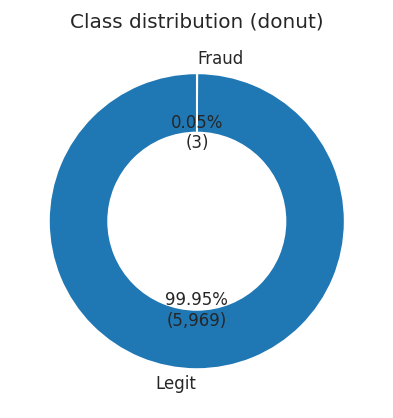

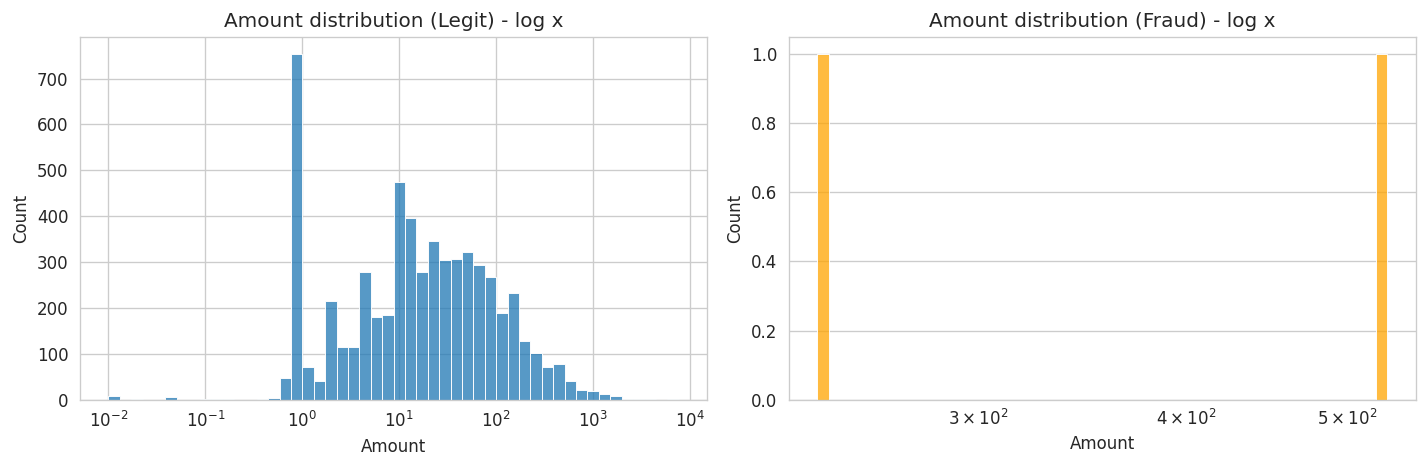

In [5]:
# QUICK CHECKS & EDA
print_divider()
print("Missing values per column:")
print(df.isnull().sum())
print_divider()
print("Class distribution:")
print(df['Class'].value_counts())
plot_class_distribution(df, 'Class')
plot_amount_distribution(df)


In [6]:
# Create a log-amount column for better visualization
df['LogAmount'] = np.log1p(df['Amount'])

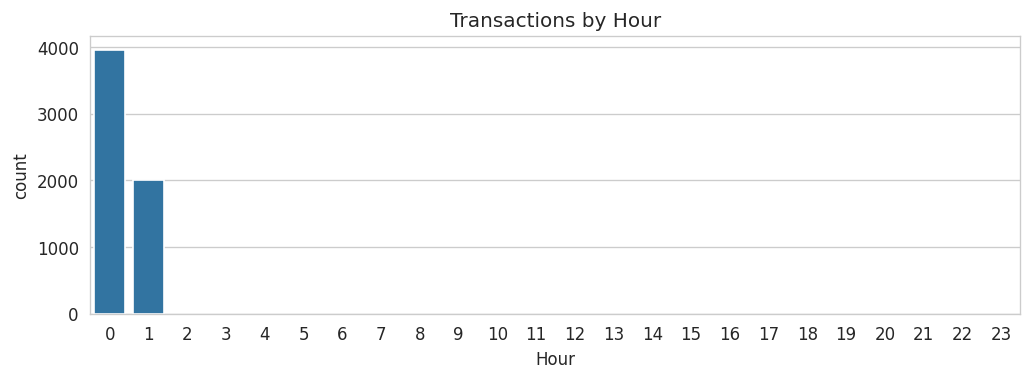

In [8]:
# create a synthetic time-of-day or date if 'Time' exists (creditcard dataset uses seconds)
if 'Time' in df.columns:
    # Convert Time (seconds from first transaction) to an artificial datetime for plotting convenience
    start = pd.Timestamp("2017-01-01")
    df['TxnDatetime'] = start + pd.to_timedelta(df['Time'], unit='s')
    # Create hour
    df['Hour'] = df['TxnDatetime'].dt.hour
    plt.figure(figsize=(10,3))
    sns.countplot(x='Hour', data=df, order=range(24))
    plt.title("Transactions by Hour")
    plt.show()

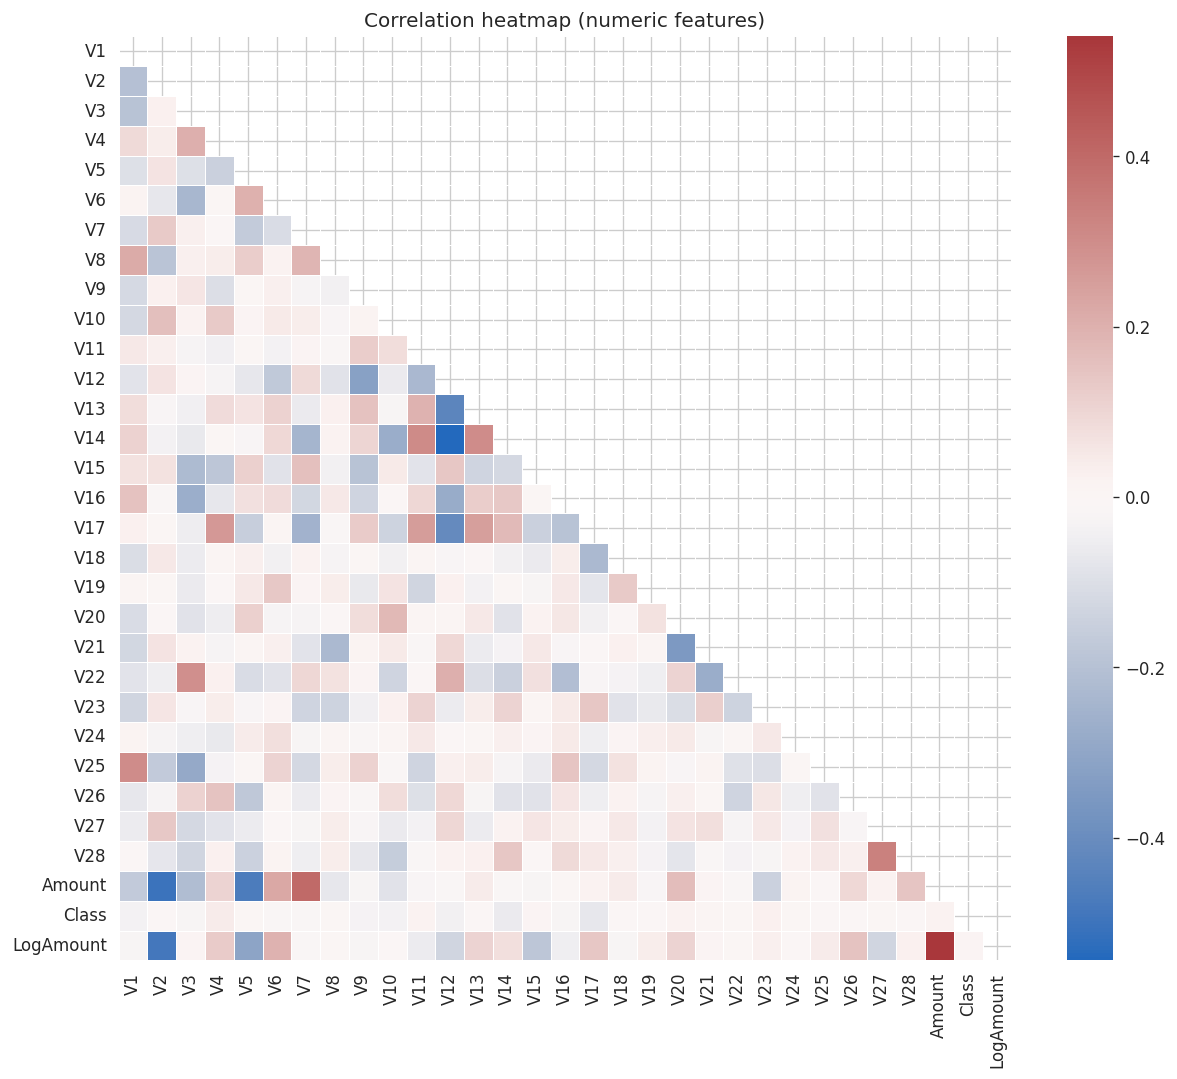

In [9]:

# Correlation heatmap on numeric columns (V1..V28 + Amount)
numeric_cols = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] and c not in ['Time']]
plot_correlation_heatmap(df, numeric_cols)

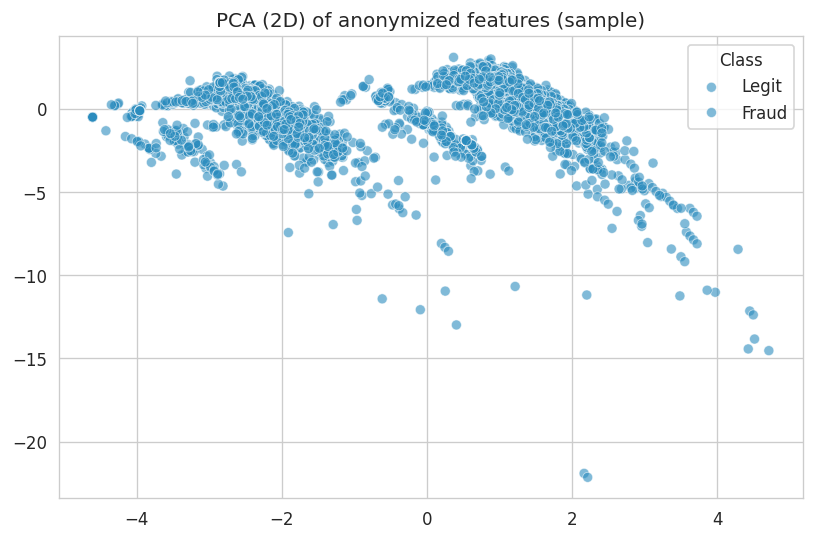

In [10]:
# PCA visual (2D) for dataset (sample to avoid heavy load)
from sklearn.decomposition import PCA
sample_df = df.sample(10000, random_state=RND) if df.shape[0] > 10000 else df.copy()
pca = PCA(n_components=2, random_state=RND)
feat_cols = [c for c in sample_df.columns if c.startswith('V')]  # anonymized features
X_pca = pca.fit_transform(sample_df[feat_cols].fillna(0))
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=sample_df['Class'], palette=['#2b8cbe','#f6903d'], alpha=0.6)
plt.title("PCA (2D) of anonymized features (sample)")
plt.legend(title='Class', labels=['Legit','Fraud'])
plt.show()

In [11]:
# PREPROCESSING
# Feature list: use V1..V28, Time (scaled), Amount (scaled), optionally Hour, LogAmount
FEATURES = [c for c in df.columns if c.startswith('V')]  # V1..V28
if 'Hour' in df.columns:
    FEATURES += ['Hour']
if 'Time' in df.columns:
    FEATURES += ['Time']

In [12]:
# We'll scale Amount separately and add LogAmount
FEATURES += ['Amount']

In [13]:
# Prepare X, y
X = df[FEATURES].copy()
y = df['Class'].copy()

In [14]:
# Fill NaNs if any
X = X.fillna(0)

In [15]:
# Scale numeric columns (Amount, Time/Hour if present and V* columns are already PCA/normalized in original dataset)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [16]:
# Save scaler for production
joblib.dump(scaler, os.path.join(MODEL_DIR, "feature_scaler.joblib"))

['models/feature_scaler.joblib']

In [18]:
# Train/test split (stratified to keep class proportions)
# Remove rows with NaN in the target variable y
X_scaled = X_scaled[y.notna()]
y = y.dropna()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=RND)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))

Train shape: (4778, 31) Test shape: (1195, 31)
Train class distribution:
 Class
0.0    0.999581
1.0    0.000419
Name: proportion, dtype: float64


In [19]:
# Option A: Use class_weight in models (logistic, random forest)
# Option B: Oversample with SMOTE (recommended for model training)
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=RND)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE, train shape:", X_train_res.shape)
except Exception as e:
    print("imblearn not installed or error with SMOTE:", e)
    print("Proceeding without resampling (using class_weight for models).")
    X_train_res, y_train_res = X_train, y_train

imblearn not installed or error with SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Proceeding without resampling (using class_weight for models).


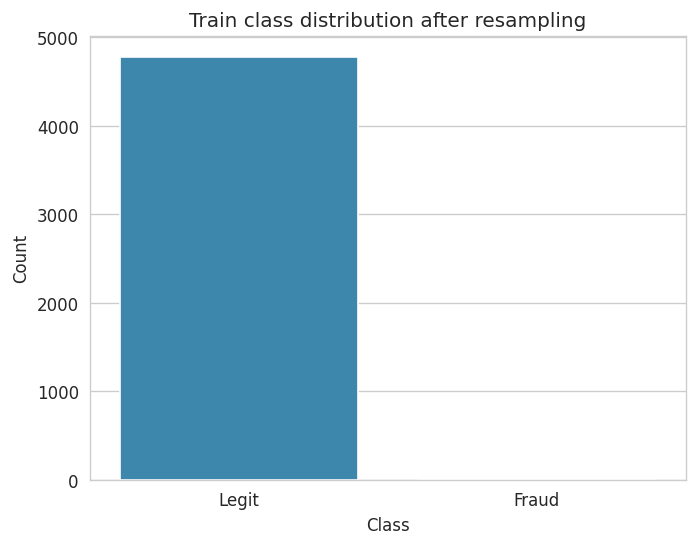

In [20]:
# Visualize class balance after resampling
try:
    import matplotlib.ticker as ticker
    counts = pd.Series(y_train_res).value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette=['#2b8cbe','#f6903d'])
    plt.xticks([0,1], ['Legit', 'Fraud'])
    plt.ylabel("Count")
    plt.title("Train class distribution after resampling")
    plt.show()
except:
    pass

In [21]:
# We'll train: LogisticRegression (balanced), RandomForest, XGBoost (if available), IsolationForest (unsupervised)
models = {}


In [22]:
# 1) Logistic Regression (fast baseline)
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RND)
lr.fit(X_train_res, y_train_res)
models['LogisticRegression'] = lr

In [23]:
# 2) Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RND, n_jobs=-1)
rf.fit(X_train_res, y_train_res)
models['RandomForest'] = rf
joblib.dump(rf, os.path.join(MODEL_DIR, "rf_model.joblib"))

['models/rf_model.joblib']

In [24]:
# 3) XGBoost (if available) — use scale_pos_weight or feed resampled data
try:
    import xgboost as xgb
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND, n_jobs=4)
    xgb_model.fit(X_train_res, y_train_res)
    models['XGBoost'] = xgb_model
    joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgb_model.joblib"))
except Exception as e:
    print("XGBoost not installed or failed:", e)

In [25]:
# 4) Isolation Forest for anomaly detection (unsupervised)
from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_estimators=200, contamination=np.mean(y_train), random_state=RND)

In [26]:
# Train on legitimate transactions only (unsupervised)
try:
    iso.fit(X_train[y_train == 0])
    models['IsolationForest'] = iso
    joblib.dump(iso, os.path.join(MODEL_DIR, "isolation_forest.joblib"))
except Exception as e:
    print("IsolationForest training failed:", e)

In [29]:
def evaluate_classifier(name, model, X_test, y_test, prob=True):
    print_divider()
    print(f"Model: {name}")
    if name == 'IsolationForest':
        # predict anomalies: -1 = anomaly -> map to 1 (fraud)
        pred = model.predict(X_test)
        y_pred = np.where(pred == -1, 1, 0)
        y_score = None
    else:
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:,1] if prob and hasattr(model, "predict_proba") else None

    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_score is not None:
        auc_score = roc_auc_score(y_test, y_score)
        print(f"ROC AUC: {auc_score:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})')
        plt.plot([0,1], [0,1], '--', color='grey')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()
          # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (AUC={pr_auc:.3f})')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.legend()
        plt.show()

    print_divider()

--------------------------------------------------------------------------------
Model: LogisticRegression
              precision    recall  f1-score   support

         0.0     0.9992    0.9992    0.9992      1194
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.9983      1195
   macro avg     0.4996    0.4996    0.4996      1195
weighted avg     0.9983    0.9983    0.9983      1195



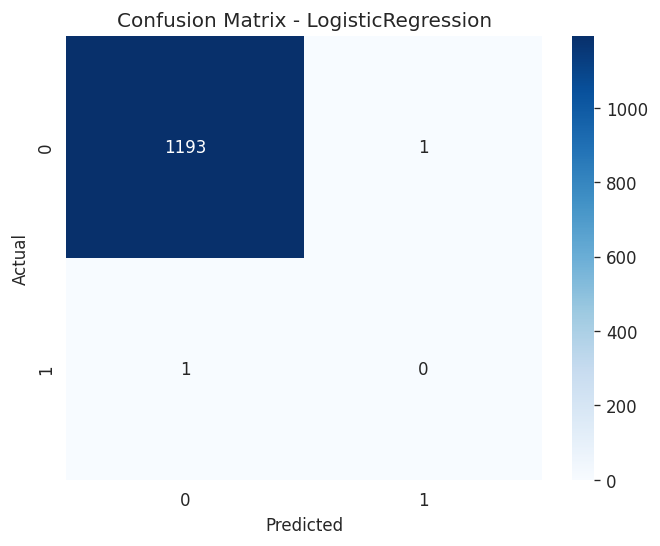

ROC AUC: 0.7437


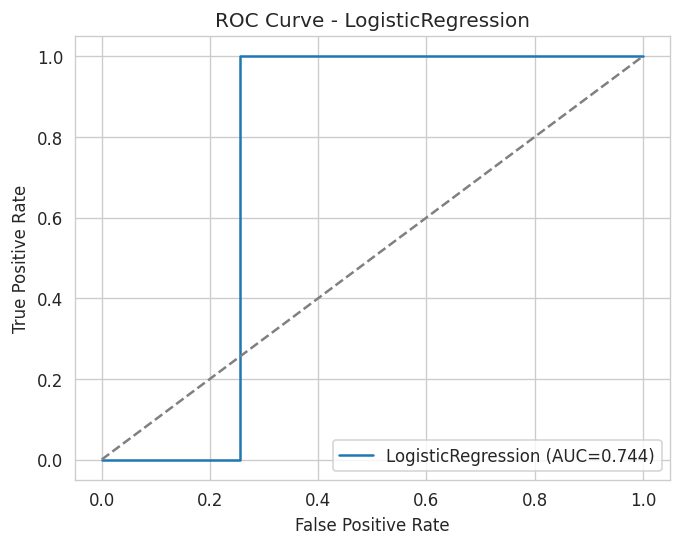

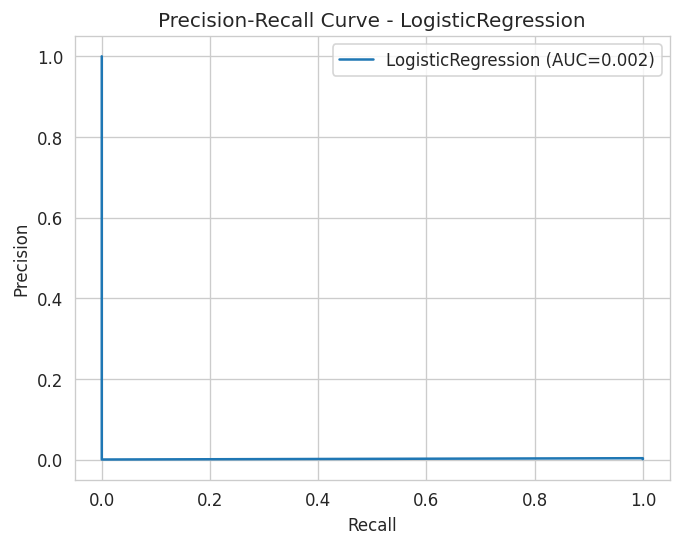

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: RandomForest
              precision    recall  f1-score   support

         0.0     0.9992    1.0000    0.9996      1194
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.9992      1195
   macro avg     0.4996    0.5000    0.4998      1195
weighted avg     0.9983    0.9992    0.9987      1195



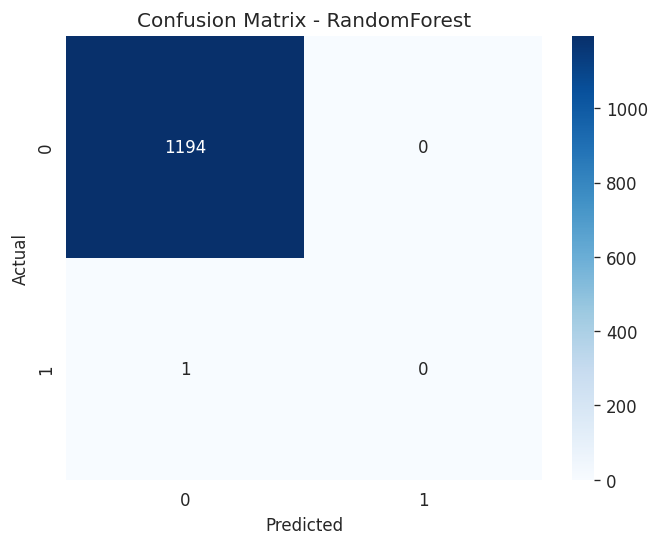

ROC AUC: 0.9975


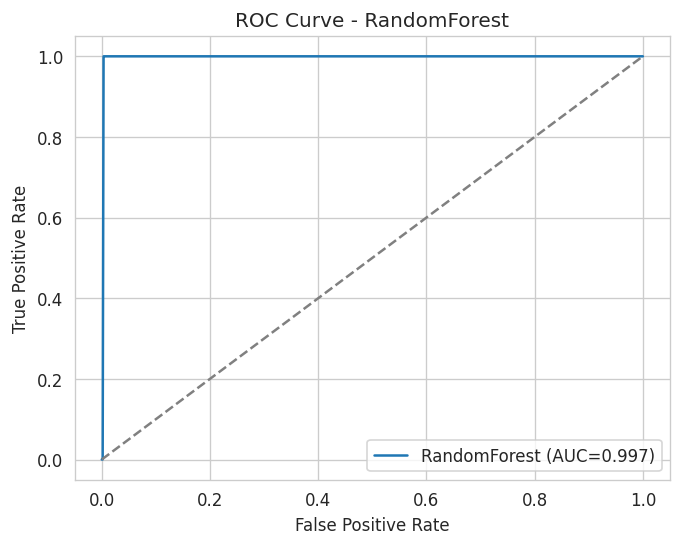

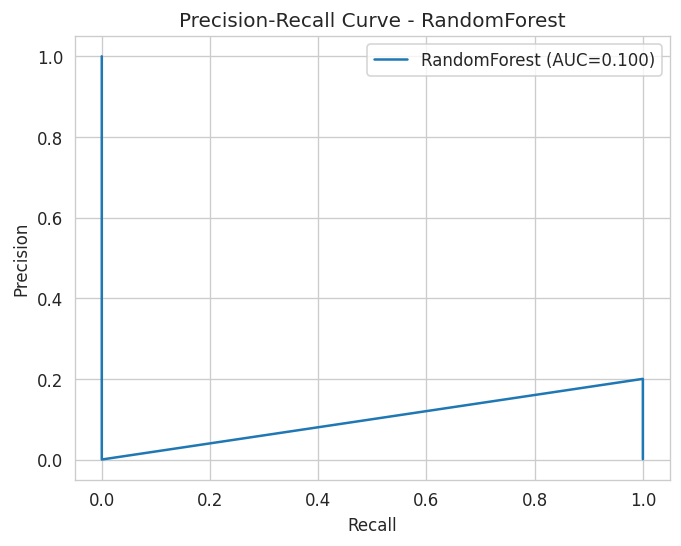

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

         0.0     0.9992    1.0000    0.9996      1194
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.9992      1195
   macro avg     0.4996    0.5000    0.4998      1195
weighted avg     0.9983    0.9992    0.9987      1195



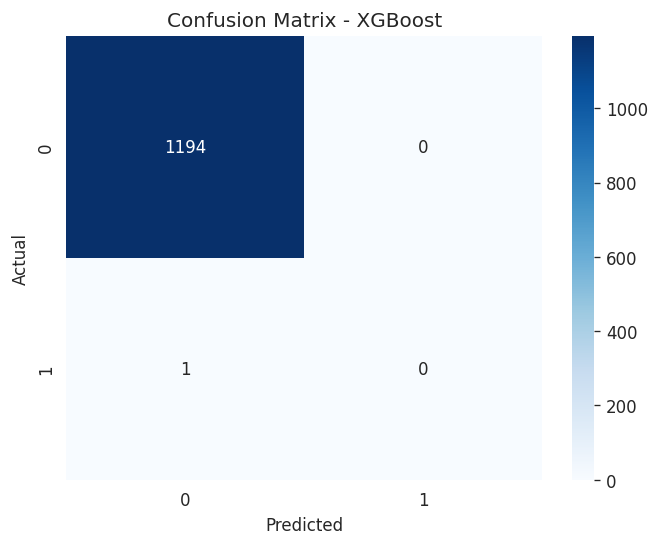

ROC AUC: 0.5000


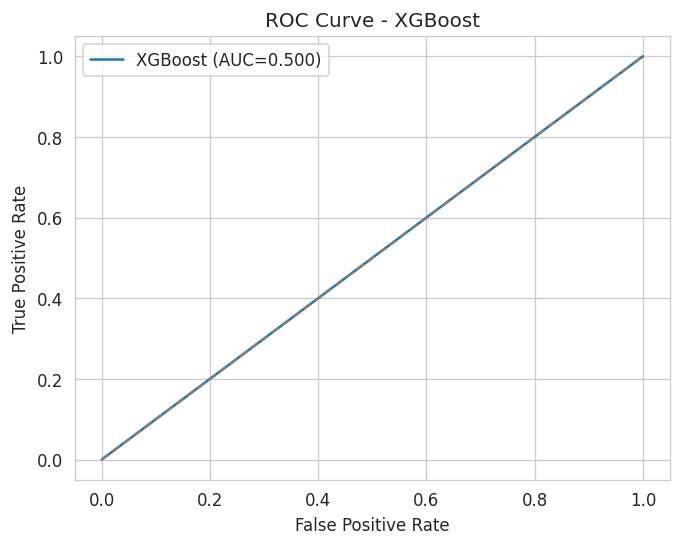

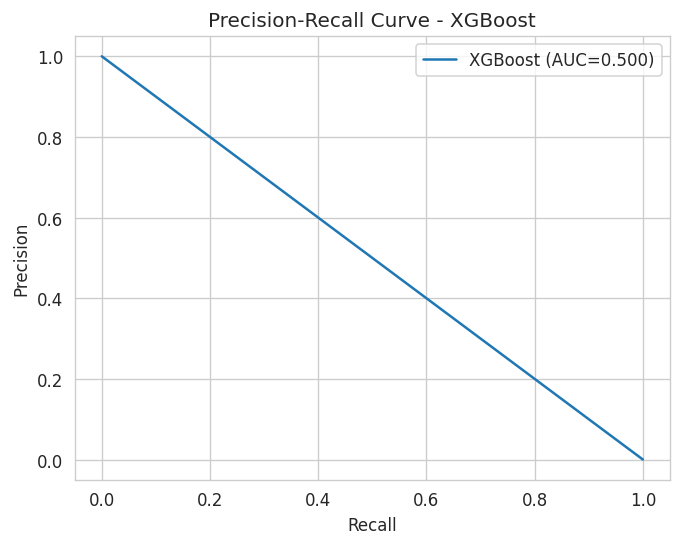

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: IsolationForest
              precision    recall  f1-score   support

         0.0     0.9992    0.9983    0.9987      1194
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.9975      1195
   macro avg     0.4996    0.4992    0.4994      1195
weighted avg     0.9983    0.9975    0.9979      1195



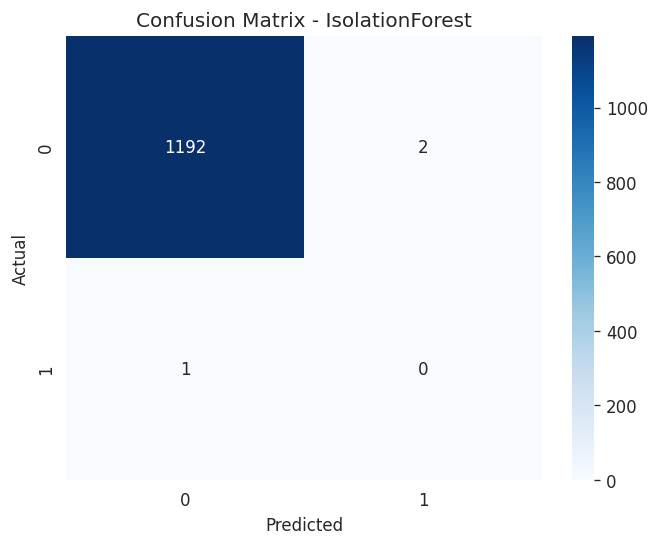

--------------------------------------------------------------------------------


In [30]:
# Evaluate all models
for name, m in models.items():
    evaluate_classifier(name, m, X_test, y_test)


In [31]:
# Create a comparison table (AUC)
rows = []
for name, m in models.items():
    if name == 'IsolationForest':
        pred = m.predict(X_test)
        y_pred = np.where(pred == -1, 1, 0)
        auc_val = roc_auc_score(y_test, y_pred)
    else:
        if hasattr(m, "predict_proba"):
            proba = m.predict_proba(X_test)[:,1]
            auc_val = roc_auc_score(y_test, proba)
        else:
            auc_val = roc_auc_score(y_test, m.predict(X_test))
    rows.append((name, auc_val))
cmp_df = pd.DataFrame(rows, columns=['Model','ROC_AUC']).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
display(cmp_df)

,Model,ROC_AUC
0,RandomForest,0.997487
1,LogisticRegression,0.743719
2,XGBoost,0.500000
3,IsolationForest,0.499162


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ROC_AUC'].plot(kind='hist', bins=20, title='ROC_AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='ROC_AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['ROC_AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('ROC_AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['ROC_AUC'].plot(kind='line', figsize=(8, 4), title='ROC_AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='ROC_AUC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [32]:
# Use StratifiedKFold because of class imbalance
param_dist_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 6, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)
rs = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RND, n_jobs=-1),
                        param_distributions=param_dist_rf, n_iter=12, cv=skf, scoring='roc_auc', random_state=RND, n_jobs=-1, verbose=1)
rs.fit(X_train_res, y_train_res)
print("Best RF params:", rs.best_params_)
best_rf = rs.best_estimator_
joblib.dump(best_rf, os.path.join(MODEL_DIR, "rf_best.joblib"))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}


['models/rf_best.joblib']

--------------------------------------------------------------------------------
Model: RandomForest (Tuned)
              precision    recall  f1-score   support

         0.0     0.9992    1.0000    0.9996      1194
         1.0     0.0000    0.0000    0.0000         1

    accuracy                         0.9992      1195
   macro avg     0.4996    0.5000    0.4998      1195
weighted avg     0.9983    0.9992    0.9987      1195



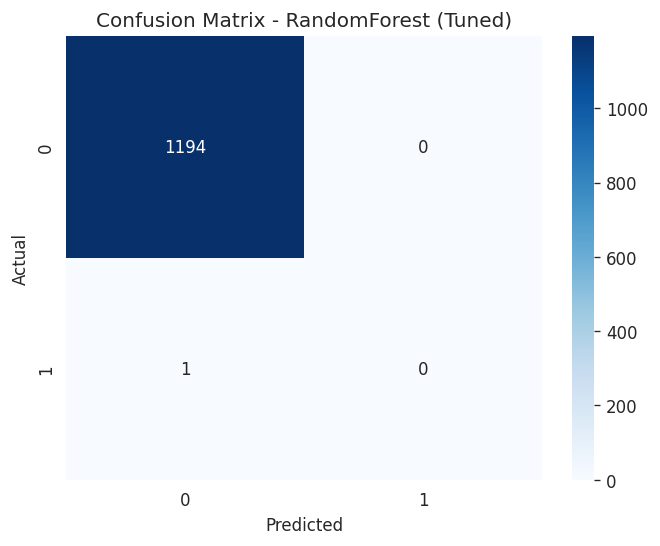

ROC AUC: 0.9941


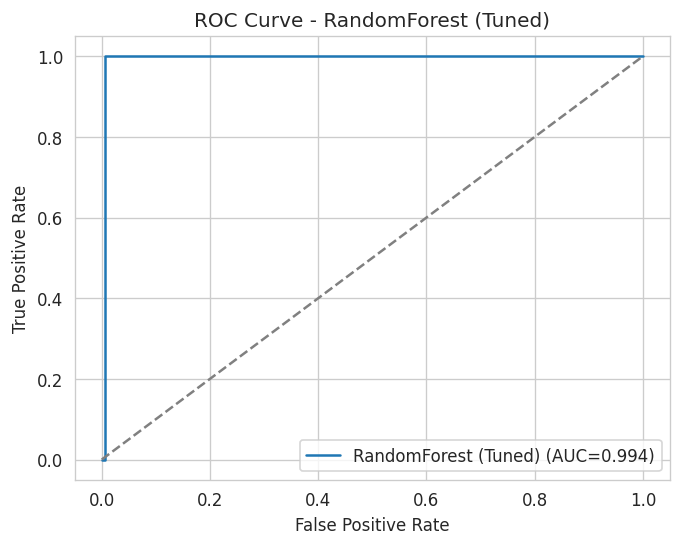

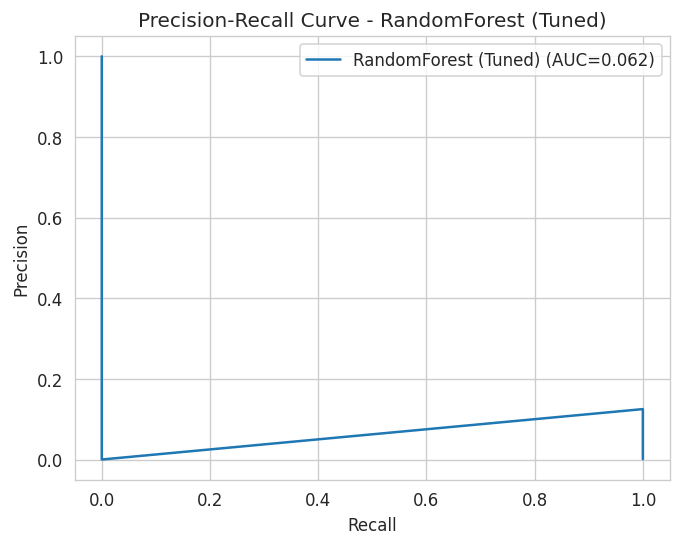

--------------------------------------------------------------------------------


In [33]:

# Evaluate best RF
evaluate_classifier("RandomForest (Tuned)", best_rf, X_test, y_test)

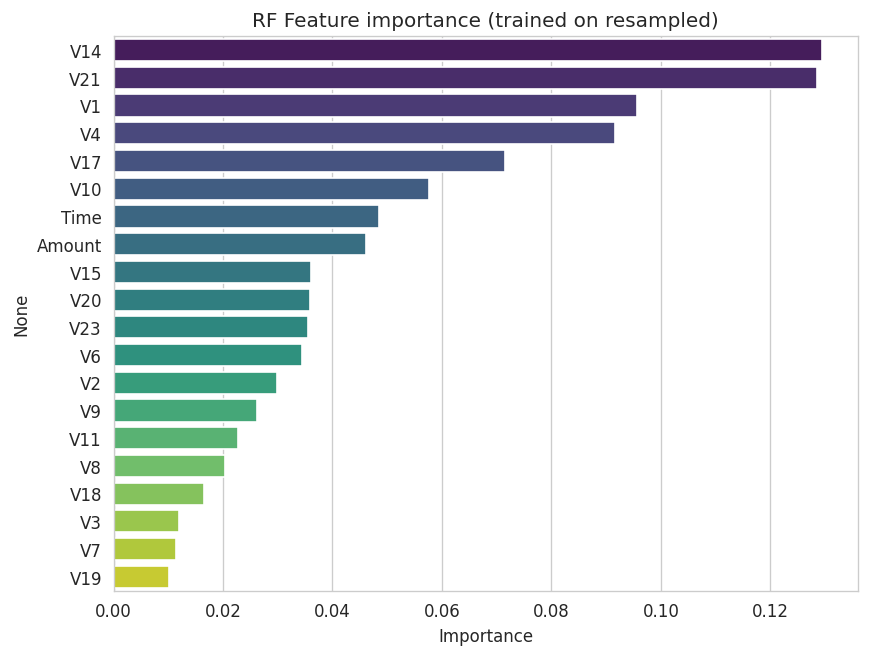

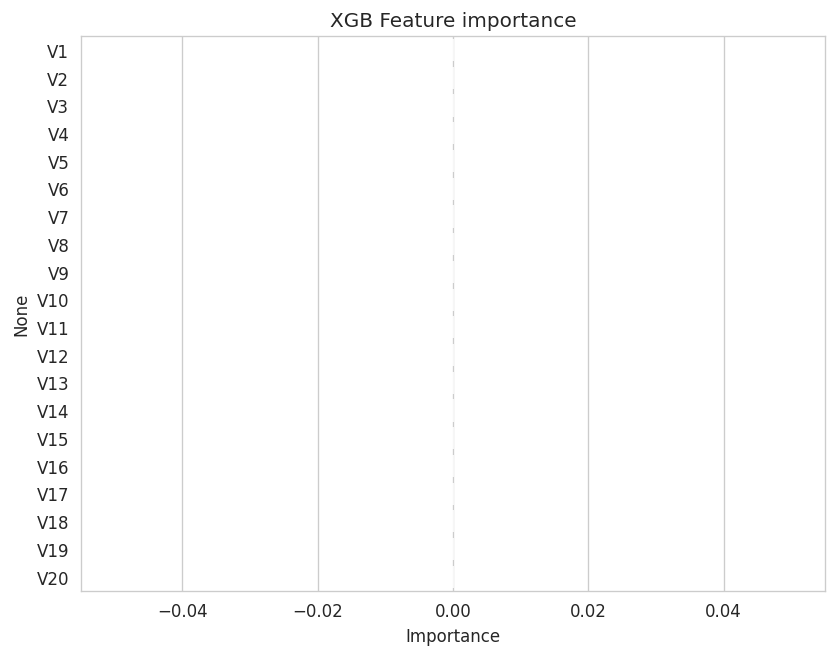

In [34]:
# FEATURE IMPORTANCE (Tree-based models)
# ----------------------------
def plot_feature_importance(model, X, top_n=20, title="Feature importance"):
    if hasattr(model, "feature_importances_"):
        fi = pd.Series(model.feature_importances_, index=X.columns).nlargest(top_n)
        plt.figure(figsize=(8,6))
        sns.barplot(x=fi.values, y=fi.index, palette="viridis")
        plt.title(title)
        plt.xlabel("Importance")
        plt.show()
    else:
        print("Model has no feature_importances_ attribute")

if 'RandomForest' in models:
    plot_feature_importance(models['RandomForest'], X_train_res, top_n=20, title="RF Feature importance (trained on resampled)")

if 'XGBoost' in models:
    plot_feature_importance(models['XGBoost'], X_train_res, top_n=20, title="XGB Feature importance")


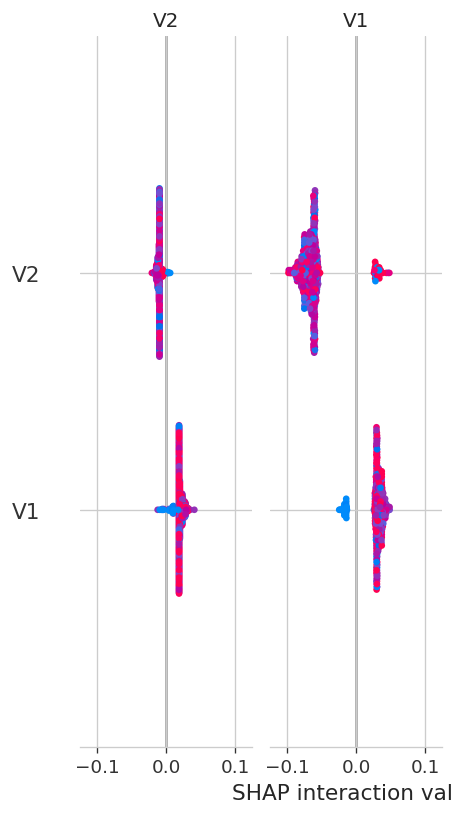

SHAP not available or failed: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50


In [35]:
# SHAP EXPLAINABILITY (optional but recommended)
try:
    import shap
    shap.initjs()
    explainer = shap.TreeExplainer(best_rf if 'best_rf' in locals() else rf)
    # sample for speed
    sample_X = X_test.sample(500, random_state=RND)
    shap_vals = explainer.shap_values(sample_X)
    # Summary plot
    shap.summary_plot(shap_vals, sample_X, plot_type="bar", show=True)
    # Dependence plot for top feature
    top_feat = sample_X.columns[np.argmax(np.abs(shap_vals).mean(axis=0))]
    shap.dependence_plot(top_feat, shap_vals, sample_X, show=True)
except Exception as e:
    print("SHAP not available or failed:", e)

In [36]:
# SAVE PREDICTIONS & ARTIFACTS
# Create predictions CSV (ensemble / best model)
pred_proba = best_rf.predict_proba(X_test)[:,1]
pred_df = X_test.copy()
pred_df['y_true'] = y_test
pred_df['y_score_best_rf'] = pred_proba
pred_df['y_pred_best_rf'] = (pred_proba >= 0.5).astype(int)
pred_df.to_csv(os.path.join(MODEL_DIR, "predictions_test_best_rf.csv"))
print("Saved predictions and models to:", MODEL_DIR)


Saved predictions and models to: models


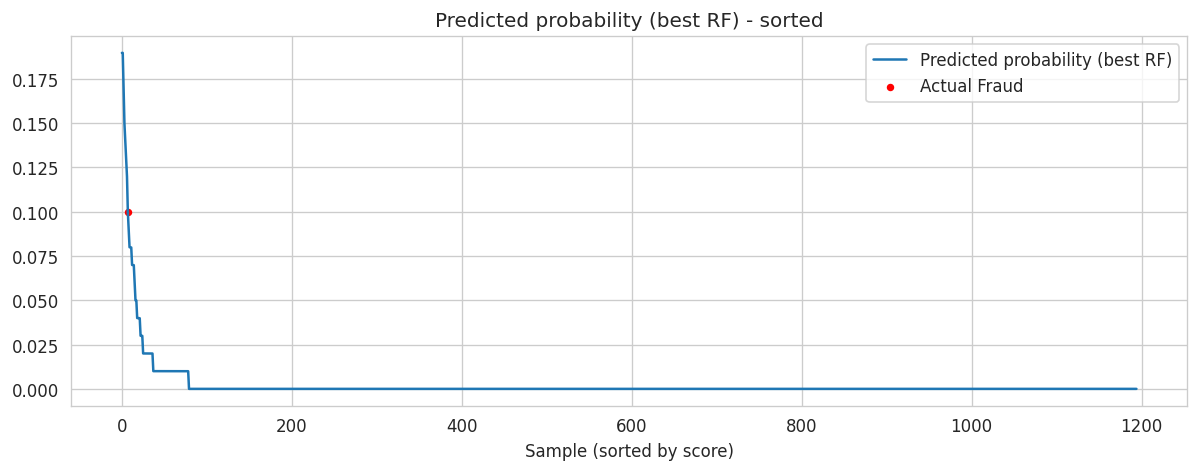

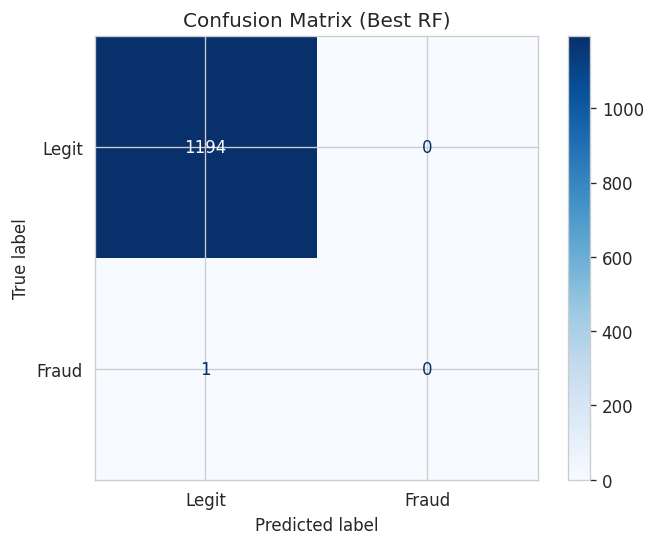

<Figure size 768x576 with 0 Axes>

In [37]:
# VISUAL: attractive combined dashboards (matplotlib + seaborn)
# 1) Actual vs Predicted probability (sorted)
viz = pred_df.sort_values('y_score_best_rf', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,4))
plt.plot(viz['y_score_best_rf'].values, label='Predicted probability (best RF)')
plt.scatter(np.where(viz['y_true'] == 1)[0], viz.loc[viz['y_true']==1, 'y_score_best_rf'], color='red', s=12, label='Actual Fraud')
plt.title("Predicted probability (best RF) - sorted")
plt.xlabel("Sample (sorted by score)")
plt.legend()
plt.show()

# 2) Confusion matrix heatmap with normalized values
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, best_rf.predict(X_test)), display_labels=['Legit','Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Best RF)")
plt.show()

# Save figure high-res
plt.savefig(os.path.join(MODEL_DIR, "confusion_matrix_best_rf.png"), dpi=200, bbox_inches='tight')


In [38]:
# OPTIONAL: Interactive Plotly visual (requires plotly)
try:
    import plotly.express as px
    sample_plot = pred_df.sample(1000, random_state=RND).reset_index()
    fig = px.scatter(sample_plot, x='V1', y='V2', color='y_score_best_rf',
                     size='y_score_best_rf', hover_data=['y_true'], title='Interactive scatter (V1 vs V2 colored by score)')
    fig.update_layout(template='plotly_white')
    fig.show()
except Exception as e:
    print("Plotly not available or failed:", e)

In [39]:
# DEPLOYMENT: Minimal Streamlit app snippet
# ----------------------------
# Save this as `app_streamlit.py` and run `streamlit run app_streamlit.py`
streamlit_snippet = """
import streamlit as st
import pandas as pd
import joblib

st.title('Fraud Detection Demo')

model = joblib.load('models/rf_best.joblib')
scaler = joblib.load('models/feature_scaler.joblib')

uploaded = st.file_uploader('Upload transactions CSV', type=['csv'])
if uploaded:
    df = pd.read_csv(uploaded)
    # assume same feature columns order/names as training
    X = df[{}]
    X_scaled = scaler.transform(X)
    probs = model.predict_proba(X_scaled)[:,1]
    df['fraud_score'] = probs
    st.dataframe(df.sort_values('fraud_score', ascending=False).head(50))
""".format(FEATURES)
print("Streamlit app snippet (save as app_streamlit.py):\n")
print(streamlit_snippet[:400], "\n...")  # truncated preview

# %%
# ----------------------------
# NEXT STEPS & NOTES
# ----------------------------
print("""
NEXT STEPS:
- Tune thresholds for precision/recall based on business costs (false positives vs false negatives).
- Use time-aware validation if transaction time ordering matters.
- Integrate additional features (merchant, device, IP, country) for improved performance.
- Productionize: REST API (FastAPI), logging, monitoring, and concept drift detection.
""")

Streamlit app snippet (save as app_streamlit.py):


import streamlit as st
import pandas as pd
import joblib

st.title('Fraud Detection Demo')

model = joblib.load('models/rf_best.joblib')
scaler = joblib.load('models/feature_scaler.joblib')

uploaded = st.file_uploader('Upload transactions CSV', type=['csv'])
if uploaded:
    df = pd.read_csv(uploaded)
    # assume same feature columns order/names as training
    X = df[['V1', 'V2', 'V3', 'V4', ' 
...

NEXT STEPS:
- Tune thresholds for precision/recall based on business costs (false positives vs false negatives).
- Use time-aware validation if transaction time ordering matters.
- Integrate additional features (merchant, device, IP, country) for improved performance.
- Productionize: REST API (FastAPI), logging, monitoring, and concept drift detection.

